In [1]:
from src.System import *

In [4]:
sl=importa("slab_332")
g =importa("Graf(CellMatch)")

Se leerá el archivo slab_332.vasp
--Red creada a partir del archivo 'slab_332.vasp'--
Se leerá el archivo Graf(CellMatch).vasp
--Red creada a partir del archivo 'Graf(CellMatch).vasp'--


In [24]:
s=system([sl,g,g.mRot(15.3)])

In [18]:
muestra2(s)


**Opción 1. T <- Matriz loMat[0] del sistema
[[[[3, -3], [12, 6]]], [[[0.9870527689702634, -0.007652067861014411], [0.0, 1.0023569046922922]]]]
Calculando numero de atomos multiplicando el numero de atomos en redes[1] por el det de la matriz en res[0],[0]
+--------------------+-------------+---------------------+-----------+---------+
|        Red         |      T      |     Deformación     |     s     | #Átomos |
+--------------------+-------------+---------------------+-----------+---------+
|      Capa 0:       | |   8    0| |     |   1    0|     |   0.000%  |   256   |
|  POSCAR_slab_332   | |   2    1| |     |   0    1|     |           |         |
|                    |             |                     |           |         |
|      Capa 1:       | |   3   -3| | | 0.98705 -0.00765| | -0.00305% |   108   |
| Grafeno(Cellmatch) | |  12    6| | |     0.0  1.00236| |           |         |
|                    |             |                     |           |         |
+-------------

Puntos de red en comun encontrados: 128
--Matriz agregada por resultados 0 y 11
--Matriz agregada por resultados 0 y 15
--Matriz agregada por resultados 1 y 16
--Matriz agregada por resultados 3 y 32
--Matriz agregada por resultados 4 y 45
--Matriz agregada por resultados 1 y 16
--Matriz agregada por resultados 4 y 32
--Matriz agregada por resultados 6 y 33
--Matriz agregada por resultados 8 y 45
--Matriz agregada por resultados 9 y 56
--Matriz agregada por resultados 6 y 15
--Matriz agregada por resultados 0 y 15
--Matriz agregada por resultados 0 y 16
Posibles Matrices de trasformación calculadas:10
Opción recomendada:
Matriz de trasformación:
	9	8
	0	2

Sistema [POSCAR_slab_332,Grafeno(Cellmatch),Grafeno(Cellmatch)(rot 15.3°)] 
Celda unitaria:


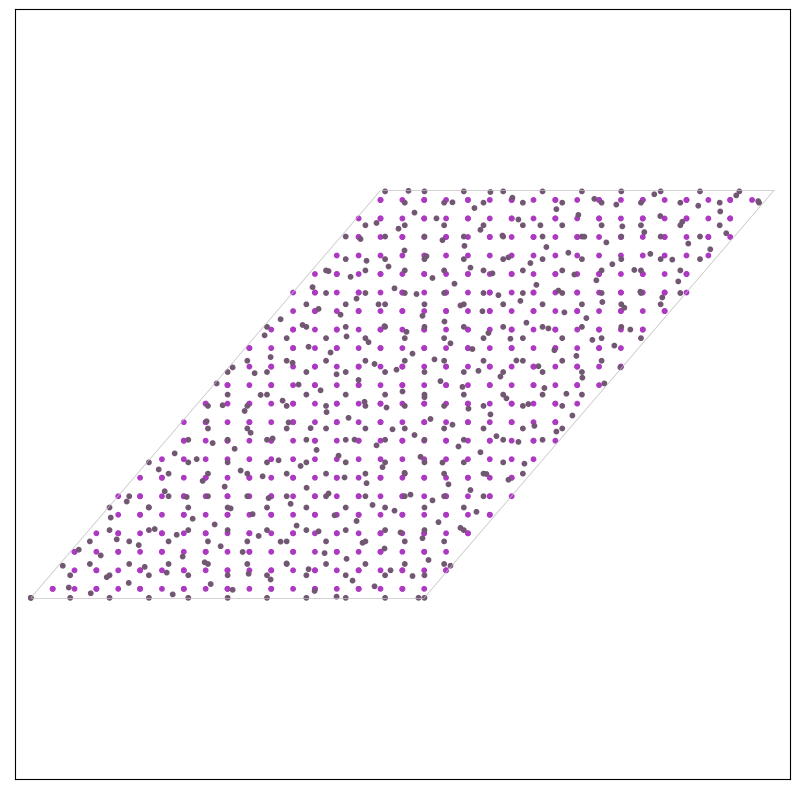

Espacio Reciproco:
Calculando...
...Pintando capa 1 (POSCAR_slab_332)
...Pintando capa 2 (Grafeno(Cellmatch))
...Pintando capa 3 (Grafeno(Cellmatch)(rot 15.3°))
...Terminado


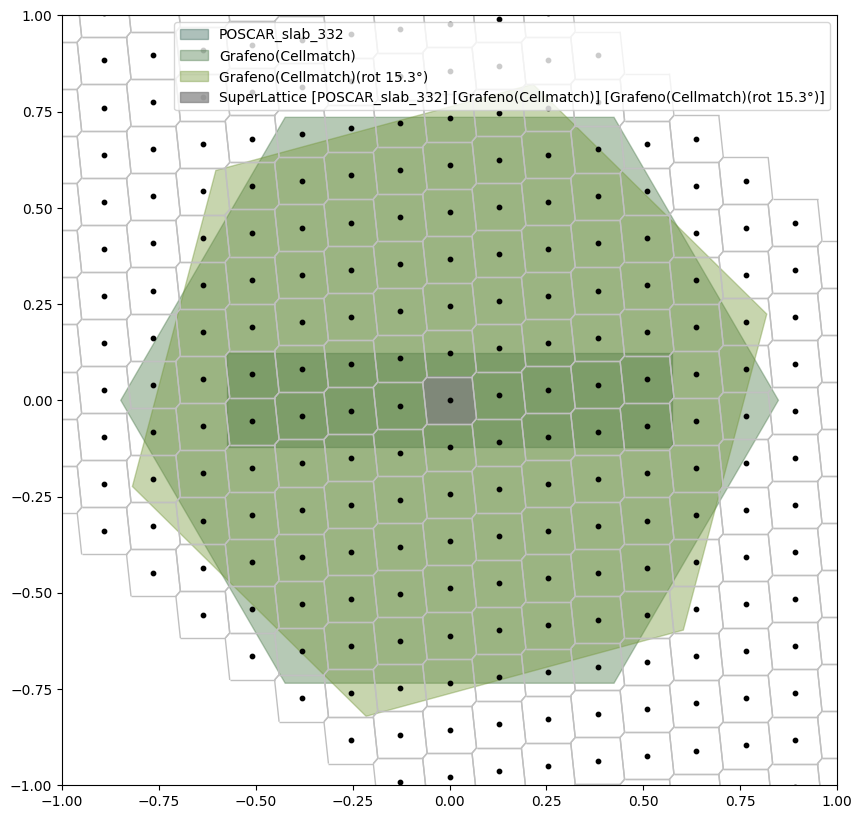

0

In [25]:
s.muestraSR(eps=0.05)

In [17]:
s.resultados

[[[0, 1], 0.004867251609713337],
 [[0, -1], 0.004867251609713337],
 [[0, 2], 0.006883333237938879],
 [[0, -2], 0.006883333237938879],
 [[0, 3], 0.008430327081244738],
 [[0, -3], 0.008430327081244738],
 [[0, 4], 0.009734503219426673],
 [[0, -4], 0.009734503219426673],
 [[1, 3], 0.026671758007858388],
 [[1, -3], 0.026671758007858388],
 [[0, 5], 0.010883505462914935],
 [[0, -5], 0.010883505462914935],
 [[1, 4], 0.023990069652796465],
 [[1, -4], 0.023990069652796205],
 [[0, 6], 0.011922282893537497],
 [[0, -6], 0.011922282893537497],
 [[1, 5], 0.022433395721690515],
 [[1, -5], 0.022433395721690515],
 [[0, 7], 0.012877537327680192],
 [[0, -7], 0.012877537327680192],
 [[1, 6], 0.021515155005412984],
 [[1, -6], 0.021515155005412984],
 [[0, 8], 0.013766666475877758],
 [[0, -8], 0.013766666475877758],
 [[1, 7], 0.020995595264967845],
 [[1, -7], 0.020995595264968185],
 [[0, 9], 0.014601754829140107],
 [[0, -9], 0.014601754829140107],
 [[1, 8], 0.020740257590383507],
 [[1, -8], 0.0207402575903835

In [26]:
Gr=importa("gr")
Gr.name="Grafene"
hBn=importa("hBn")
hBn.name="hBN"
Ph=importa("Ph")
Ph.name="Ph"

Se leerá el archivo gr.vasp
--Red creada a partir del archivo 'gr.vasp'--
Se leerá el archivo hBn.vasp
--Red creada a partir del archivo 'hBn.vasp'--
Se leerá el archivo Ph.vasp
--Red creada a partir del archivo 'Ph.vasp'--


Puntos de red en comun encontrados: 9
--Matriz agregada por resultados 0 y 2
--Matriz agregada por resultados 0 y 4
--Matriz agregada por resultados 2 y 2
--Matriz agregada por resultados 2 y 3
--Matriz agregada por resultados 2 y 3
--Matriz agregada por resultados 5 y 4
--Matriz agregada por resultados 5 y 6
--Matriz agregada por resultados 4 y 7
--Matriz agregada por resultados 4 y 4
--Matriz agregada por resultados 4 y 5
--Matriz agregada por resultados 4 y 7
--Matriz agregada por resultados 8 y 6
Posibles Matrices de trasformación calculadas:10
Opción recomendada:
Matriz de trasformación:
	3	7
	-29	11

Sistema [hBN,Ph(rot 3.8°),Grafene(rot 18.1°)] 
Celda unitaria:


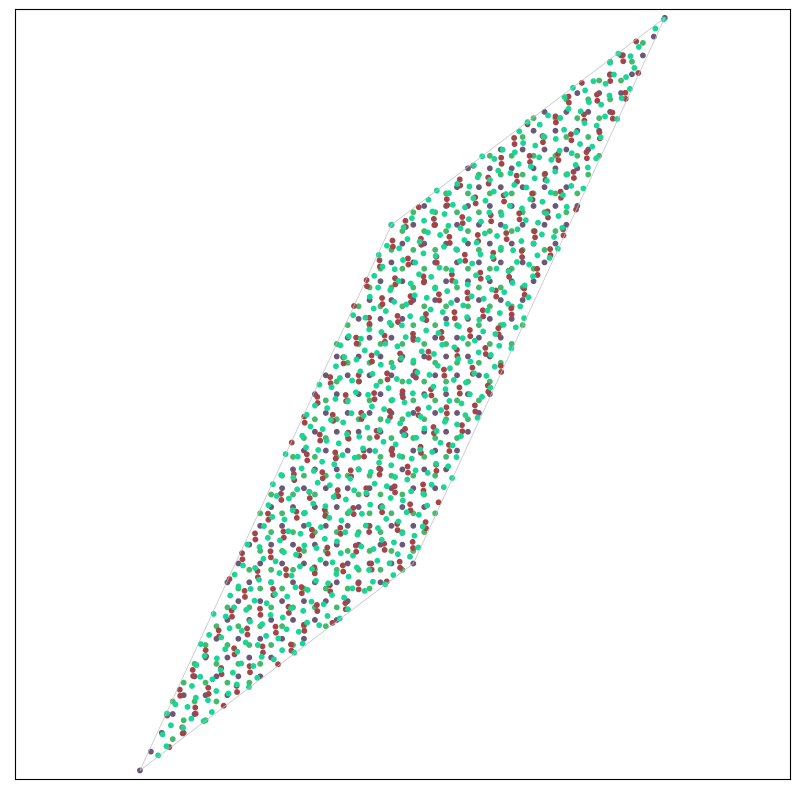

Espacio Reciproco:
Calculando...
...Pintando capa 1 (hBN)
...Pintando capa 2 (Ph(rot 3.8°))
...Pintando capa 3 (Grafene(rot 18.1°))
...Terminado


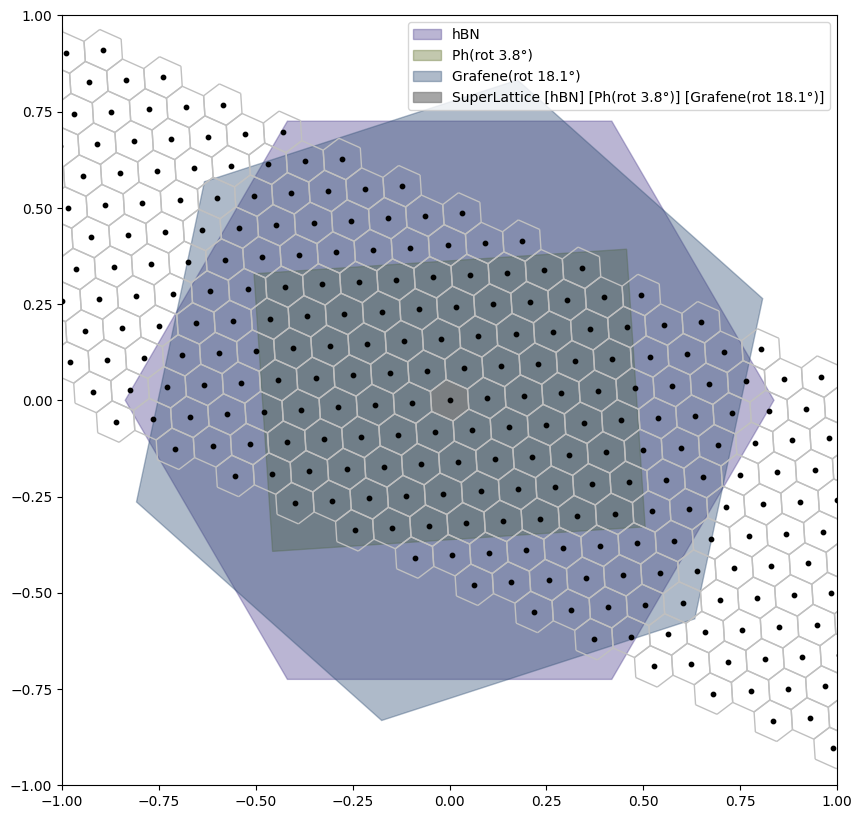

0

In [27]:
hpg=system([hBn,Ph.mRot(3.8),Gr.mRot(18.1)])
hpg.muestraSR(range_search=30,eps=0.03)

In [28]:
muestra2(hpg)


**Opción 1. T <- Matriz loMat[0] del sistema
[[[[-10, 10], [-14, 5]], [[-7, 12], [-24, 6]]], [[[1.004157503315937, 0.0030128832304684855], [-6.458612887674103e-05, 0.9989553908646048]], [[1.0007491846523306, 0.004862383743544252], [0.011053041149710119, 0.9884818964262134]]]]
Calculando numero de atomos multiplicando el numero de atomos en redes[1] por el det de la matriz en res[0],[0]
Calculando numero de atomos multiplicando el numero de atomos en redes[2] por el det de la matriz en res[0],[1]
+--------------------+-------------+---------------------+-----------+---------+
|        Red         |      T      |     Deformación     |     s     | #Átomos |
+--------------------+-------------+---------------------+-----------+---------+
|      Capa 0:       | |   3    7| |     |   1    0|     |   0.000%  |   472   |
|        hBN         | | -29   11| |     |   0    1|     |           |         |
|                    |             |                     |           |         |
|      Capa 

In [30]:
hpg.SuperRed.exporta()

1

In [ ]:
s=system([grafeno(),grafeno().mRot(13.17),grafeno().mRot(21.78)])

In [ ]:
M=[[6,13],[36,47]]
hpg.createSuperLattice(M)
hpg.show()

In [ ]:
sp=superMesh((100,0),(0,100),[hBn,Ph.mRot(3.8),Gr.mRot(18.1)])
sp.showme()

In [ ]:
s.muestraSR()

In [ ]:
sr1=s1.SuperRed
s2=system([sr1,grafeno().mRot(21.78)])

In [ ]:
s2.muestraSR()

In [2]:
def its_hexagonal_system(self):
    '''
    Señala si el sistema está conformado sólo por redes hexagonales.
    '''
    err = 10**-6
    for r in self.redes:
        if abs(120.0-r.inAngle)>err:
            return False
    return True

In [ ]:
s0=system([grafeno(),grafeno3(),hexa6(1.26),blackPhospho()])
its_hexagonal_system(s0)

In [13]:
def corresponding_points(l1, l2, M):
    a1, b1 = mTv(M)
    a2, b2 = (calcCD(l1,l2,a1),calcCD(l1,l2,b1))
    return vTm(a2,b2)

def optimize_system(s0:system, T):
    s = s0.clon()
    s.name = s.name + "Opt"
    if len(s.redes)<2:
        return -1
    V_0 = vTm(s.redes[0].a,s.redes[0].b)
    V_s = m2M(V_0,T)
    deformaciones = []
    for i in range(1,len(s.redes)):
        V_i = vTm(s.redes[i].a,s.redes[i].b)
        T_i = corresponding_points(s.redes[0], s.redes[i], T)
        V_i_Op = m2M(V_s,inv2x2(T_i))
        S_i = m2M(inv2x2(V_i),V_i_Op)
        #Guarda la matríz de deformación
        deformaciones.append(S_i)
        #Actualiza la red en la capa con los nuevos vectores primitivos
        a, b = mTv(V_i_Op)
        s.redes[i].setNewVectors(a,b)
        s.redes[i].name = s.redes[i].name + "(Opt)"
    #Creando super Red para el sistema deformado
    s.createSuperLattice(T)
    s.show()
    return s, deformaciones

In [ ]:
hpg2, dfm = optimize_system(hpg,hpg.loMat[0])

In [ ]:
V_0 = vTm(hpg2.redes[0].a,hpg2.redes[0].b)
V_s = m2M(V_0,hpg.loMat[0])
u,v = mTv(V_s)
print("Vectores esperados:{},{}".format(u,v))
for i in range(1,len(hpg2.redes)):
    V_i = vTm(hpg2.redes[i].a,hpg2.redes[i].b)
    T_i = corresponding_points(hpg2.redes[0], hpg2.redes[i],hpg.loMat[0])
    u,v = mTv(m2M(V_i,T_i))
    print("Vectores capa{}:{},{}".format(i,u,v))

In [ ]:
V_0 = vTm(hpg.redes[0].a,hpg.redes[0].b)
V_s = m2M(V_0,hpg.loMat[0])
u,v = mTv(V_s)
print("Vectores esperados:{},{}".format(u,v))
for i in range(1,len(hpg2.redes)):
    V_i = vTm(hpg.redes[i].a,hpg.redes[i].b)
    T_i = corresponding_points(hpg.redes[0], hpg.redes[i],hpg.loMat[0])
    u,v = mTv(m2M(V_i,T_i))
    print("Vectores capa{}:{},{}".format(i,u,v))

In [11]:
def calc_def(s:system, T):
    if len(s.redes)<2:
        return None, None
    V_0 = vTm(s.redes[0].a,s.redes[0].b)
    V_s = m2M(V_0,T)
    deformaciones = []
    Ts = []
    for i in range(1,len(s.redes)):
        V_i = vTm(s.redes[i].a,s.redes[i].b)
        #Calculamos la Matriz de trasformación de la capa actual y la guardamos.
        T_i = corresponding_points(s.redes[0], s.redes[i], T)
        Ts.append(T_i)
        #Calculamos la matriz de deformación y la guardamos
        V_i_Op = m2M(V_s,inv2x2(T_i))
        S_i = m2M(inv2x2(V_i),V_i_Op)
        deformaciones.append(S_i)
        print
    return [Ts, deformaciones]

def strain(M:list[list,list]):
    [[a,b],[c,d]] = M
    return det([[a-1,b],[c,d-1]])

def muestra2(s):
    '''
    Muestra una tabla con las caracteristicas de los mejores resultados para las trasnformaciones requeridas para la super Red que describa el sistema r2 sobre r1.
    lor -> Lista de resultados obtenidos de la funciòn 'analiza'
    r1  -> Red1
    r2  -> Red2
    '''
    cont = 1
    for M in s.loMat:
        print("\n**Opción {}. T <- Matriz loMat[{}] del sistema".format(cont,cont-1))
        table = PrettyTable(["Red","T","Deformación","s","#Átomos"])
        res = calc_def(s,M)
        print(res)
        err = 0.0
        totalAtms = s.redes[0].nOAtms()*det(M)
        table.add_row(["Capa 0:\n" + s.redes[0].name,
                       mtoStr(M),
                       mtoStr([[1,0],[0,1]]),
                       "{:.3f}%".format(0.0),
                       totalAtms])
        
        for i in range(len(res[0])):
            print("Calculando numero de atomos multiplicando el numero de atomos en redes[{}] por el det de la matriz en res[0],[{}]".format(i+1,i))
            atms = s.redes[i+1].nOAtms() * det(res[0][i])
            totalAtms += atms
            c_err = strain(res[1][i])*100
            err += abs(c_err)
            table.add_row(["Capa {}:\n".format(i+1) + s.redes[i+1].name,
                           mtoStr(res[0][i]),
                           mtoStr(res[1][i]),
                           "{:.5f}%".format(c_err),
                           atms])
        cont+=1
        print(table)
        print("\t\tTotal de Átomos:{}\tDeformación Promedio:{:.5f}%".format(totalAtms,err/len(res)))


In [ ]:
muestra2(hpg)

In [ ]:
muestra2(hpg2)

In [ ]:
mtoStr([[5.2222,3.4581001],[7,6]])

In [ ]:
strS(5.2222)

In [ ]:
type(5.2222)

In [ ]:
hpg.resultados

In [ ]:
(c,d) = calcCD(hpg.redes[0],hpg.redes[1],(7, 11))
p_1 = m2V(hpg.redes[0].a,hpg.redes[0].b,(7, 11))
p_2 = m2V(hpg.redes[1].a,hpg.redes[1].b,(c,d))
dist(p_1,p_2)

In [ ]:
cAng(m2V(hpg.redes[0].a,hpg.redes[0].b,(7, 11)),m2V(hpg.redes[0].a,hpg.redes[0].b,(26, -2)))

In [ ]:
hpg.SuperRed.reciprocalVectors

In [ ]:
hpg2.SuperRed.reciprocalVectors

In [ ]:
hpg2.SuperRed.exporta()
hpg.SuperRed.exporta()

In [ ]:
va,vb,th=hpg2.redes[2].a,hpg2.redes[2].b, cAng(hpg2.redes[2].a,hpg2.redes[2].b)
print("Red Grafeno Optimizada:\n\t a={},b={}\n\t|a|={:.5f},|b|={:.5f},Theta={:.5}".format(va,vb,long(va),long(vb),th))

In [ ]:
va,vb,th=hpg.redes[2].a,hpg.redes[2].b,cAng(hpg.redes[2].a,hpg.redes[2].b)
print("Red Grafeno Original:\n\ta={},b={}\n\t|a|={:.5f},|b|={:.5f},Theta={:.5f}".format(va,vb,long(va),long(vb),th))

In [ ]:
s,d=strain([[1.002,0.004],[0.002,0.994]]), det([[1.002,0.004],[0.002,0.994]])
s/det(vTm(hpg.redes[0].a,hpg.redes[0].b))

In [ ]:
def cosa(d,t):
    th=t*math.pi/180
    return strain([[d*math.cos(th),-d*math.sin(th)],[d*math.sin(th),d*math.cos(th)]])

In [ ]:
thetas = []
dif = []
strains = []
for i in range(1800):
    ths = []
    di = []
    st = []
    for j in range(401):
        d = j/100
        th = i/10
        s = cosa(d,th)
        ths.append(th)
        di.append(d)
        st.append(s)
        #print("Dif={},Theta={}º \n\tstrain={}\n".format(d,th,s))
    thetas.append(ths)
    dif.append(di)
    strains.append(st)
thetas = np.array(thetas)
dif = np.array(dif)
strains = np.array(strains)

In [ ]:
fig= plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(dif,thetas,strains,cmap='viridis',alpha=0.9)
plt.show()

In [ ]:
len(X[0])

In [5]:
def calcCD2(vs, us, ab):
    '''
    Dadas 2 redes 'substrate' y 'layer' calcula los enteros 'c' y 'd' tales que para los
    vectores primitivos de 'substrate' (u,v) y los vectores primitivos de 'layer' (p,q)
    \$p'= cp + dq\$, aproxime a \$p = au + bv\$.
    substrate -> Red base.
    layer     -> Red por aproximar
    ab        -> Pareja de enteros que definen al vector que queremos aproximar
    '''
    (a,b) = ab
    (u,v), (p,q) = vs, us
    (u_1,u_2), (v_1,v_2) = u, v
    (p_1,p_2), (q_1,q_2) = p, q
    eq0 = (p_2*q_1)-(p_1*q_2)
    eq1 = (q_1*u_2)-(q_2*u_1)
    eq2 = (q_1*v_2)-(q_2*v_1)
    eq3 = (p_2*u_1)-(p_1*u_2)
    eq4 = (p_2*v_1)-(p_1*v_2)
    c = ((eq1*a)+(eq2*b))/(eq0)
    d = ((eq3*a)+(eq4*b))/(eq0)
    return (round(c),round(d)),(c,d)

In [6]:
u,v,p,q = (7.23,1.13),(-2.1,6.25),(2.98,5.2),(-8.225,-0.98)

In [7]:
r1 = grafeno()
r2 = grafeno()
r1.setNewVectors(u,v)
r2.setNewVectors(p,q)

In [8]:
s = system([r1,r2])

Puntos de red en comun encontrados: 78
--Matriz agregada por resultados 0 y 2
--Matriz agregada por resultados 1 y 3
--Matriz agregada por resultados 2 y 5
--Matriz agregada por resultados 3 y 7
--Matriz agregada por resultados 4 y 10
--Matriz agregada por resultados 3 y 15
--Matriz agregada por resultados 4 y 16
--Matriz agregada por resultados 7 y 19
--Matriz agregada por resultados 8 y 20
--Matriz agregada por resultados 8 y 23
--Matriz agregada por resultados 7 y 26
--Matriz agregada por resultados 6 y 31
--Matriz agregada por resultados 5 y 35
--Matriz agregada por resultados 1 y 2
--Matriz agregada por resultados 3 y 3
--Matriz agregada por resultados 8 y 13
--Matriz agregada por resultados 3 y 5
--Matriz agregada por resultados 8 y 15
--Matriz agregada por resultados 7 y 45
Posibles Matrices de trasformación calculadas:10
Opción recomendada:
Matriz de trasformación:
	1	3
	-3	2

Sistema [Grafeno,Grafeno] 
Celda unitaria:


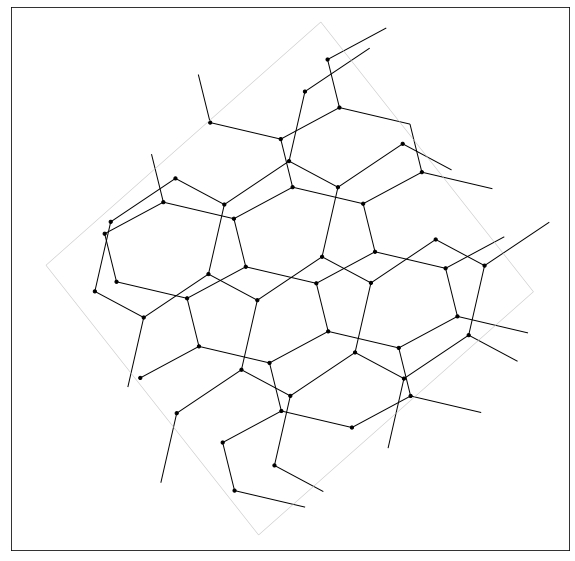

Espacio Reciproco:
Calculando...
...Pintando capa 1 (Grafeno)
...Pintando capa 2 (Grafeno)
...Terminado


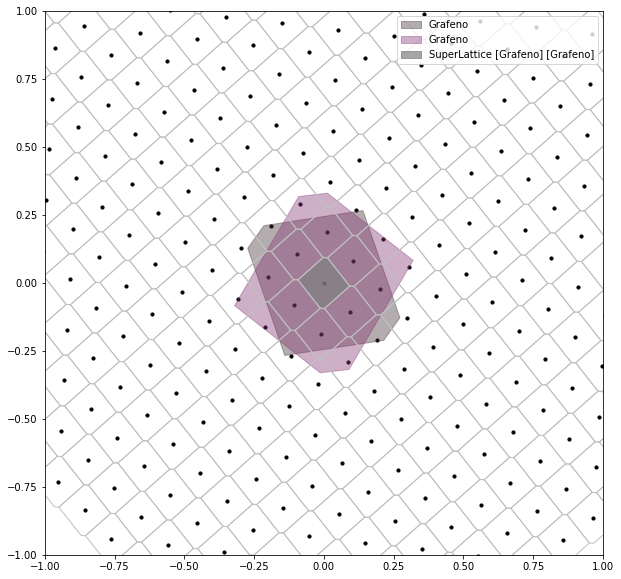

0

In [12]:
s.muestraSR()

In [ ]:
a1,b1,a2,b2 = 5,7,2,3
(c1,d1),(cx1,dx1)=calcCD2((u,v),(p,q),(a1,b1))
(c2,d2),(cx2,dx2)=calcCD2((u,v),(p,q),(a2,b2))
c1,d1,c2,d2,cx1,dx1,cx2,dx2

In [ ]:
m2V(u,v,(a1,b1)),m2V(p,q,(c1,d1))

In [ ]:
s.redes[1].b

In [14]:
corresponding_points(r1,r2,s.loMat[0])

[[-4, 3], [-3, -1]]

In [13]:
transforma2v(u,v,s.loMat[0])

((13.530000000000001, -17.62), (17.490000000000002, 15.89))

In [15]:
transforma2v(p,q,[[-4, 3], [-3, 1]])

((12.754999999999997, -17.86), (0.7149999999999999, 14.620000000000001))

In [ ]:
s.loMat[0]

In [ ]:
s.resultados

In [23]:
muestra2(s)


**Opción 1. T <- Matriz loMat[0] del sistema
[[[[-4, 3], [-3, -1]]], [[[0.9629457722575346, 0.03924660569896665], [-0.01529558833521738, 1.0481217068485196]]]]
Calculando numero de atomos multiplicando el numero de atomos en redes[1] por el det de la matriz en res[0],[0]
+---------+-------------+---------------------+-----------+---------+
|   Red   |      T      |     Deformación     |     s     | #Átomos |
+---------+-------------+---------------------+-----------+---------+
| Capa 0: | |   1    3| |     |   1    0|     |   0.000%  |    22   |
| Grafeno | |  -3    2| |     |   0    1|     |           |         |
|         |             |                     |           |         |
| Capa 1: | |  -4    3| | | 0.96295  0.03925| | -0.11828% |    26   |
| Grafeno | |  -3   -1| | | -0.0153  1.04812| |           |         |
|         |             |                     |           |         |
+---------+-------------+---------------------+-----------+---------+
		Total de Átomos:48	Deform

In [17]:
calc_def(s,s.loMat[0])

[[[[-4, 3], [-3, -1]]],
 [[[0.9629457722575346, 0.03924660569896665],
   [-0.01529558833521738, 1.0481217068485196]]]]

Matriz de trasformación:
	1	3
	-3	2

Sistema [Grafeno,Grafeno]Opt 
Celda unitaria:


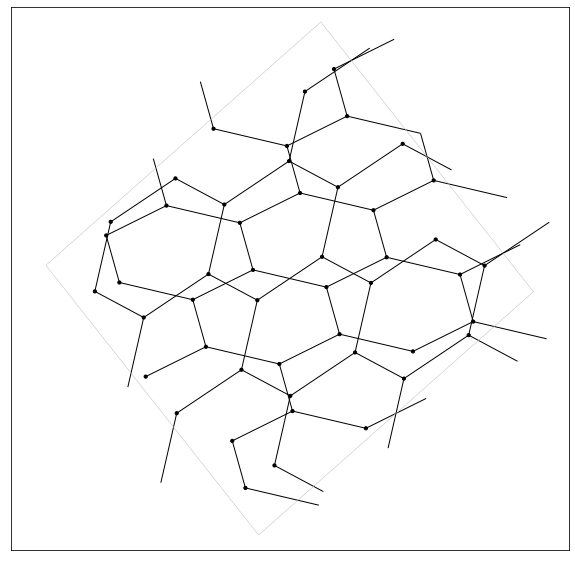

Espacio Reciproco:
Calculando...
...Pintando capa 1 (Grafeno)
...Pintando capa 2 (Grafeno(Opt))
...Terminado


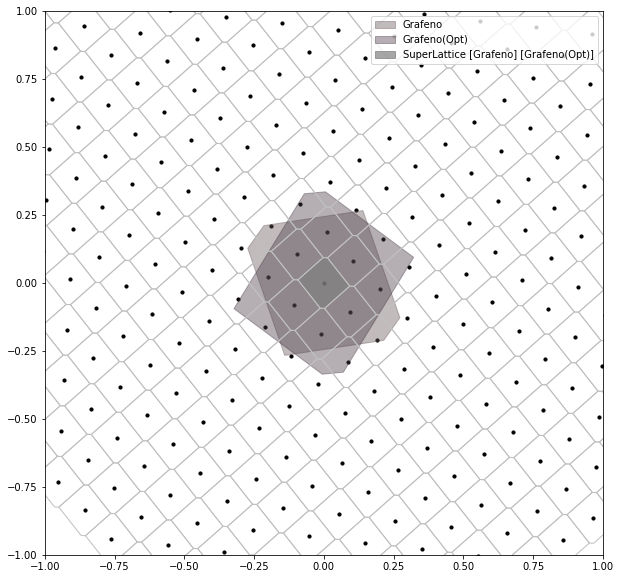

In [31]:
s2,d=optimize_system(s,s.loMat[0])

In [32]:
for r in s2.redes:
    print("\n",r.name)
    print(r.a)
    print(r.b)


 Grafeno
(7.23, 1.13)
(-2.1, 6.25)

 Grafeno(Opt)
(2.995384615384616, 5.0223076923076935)
(-8.503846153846155, -0.8230769230769228)


In [33]:
for r in s.redes:
    print("\n",r.name)
    print(r.a)
    print(r.b)


 Grafeno
(7.23, 1.13)
(-2.1, 6.25)

 Grafeno
(2.98, 5.2)
(-8.225, -0.98)


In [39]:
u=(2.98, 5.2)
v=(2.995384615384616, 5.0223076923076935)

In [41]:
long(v)/long(u)

0.9757003474323663

In [42]:
cAng(u,v)

0.9924044170780022

In [43]:
d

[[[0.9629457722575346, 0.03924660569896665],
  [-0.01529558833521738, 1.0481217068485196]]]